In [ ]:
#install snorkel for weak supervision
cd snorkel
! pip install .
cd ..
! pip install future

This should work, but if any problems occur, see- [https://github.com/HazyResearch/snorkel#quick-start](https://github.com/HazyResearch/snorkel#quick-start)

# Data Exploration

## Our Dataset

Our dataset was built using Kaggle API and Scraping and it contains:
- ~50 different datasets
- ~7k Jupyter Notebooks
- ~90k code cells (Unlabled)

In [1]:
# Importing required modules and functions
import csv
import statistics
from typing import Dict
from utils import utils
from utils import consts
from utils.Graphs import *
from utils.simpleDataExplorationScripts import sumOfLines, countPrintCells, printDesiredData, isCellUseless

# Handeling the "field larger than field limit" error
incrementMemory()

## Data Exploration

#### Cells per Number of Lines:

There are 26840 cells that only display data and doesn't manipulate it (print/display/show/comments).
Number of cells with 0 :: 2839
Mean: 3.4020568875064345
Median: 1
Max: 947
Min: 1
Total num of lines: 310618
Total num of cells: 91303
Average number of lines per cell: 3


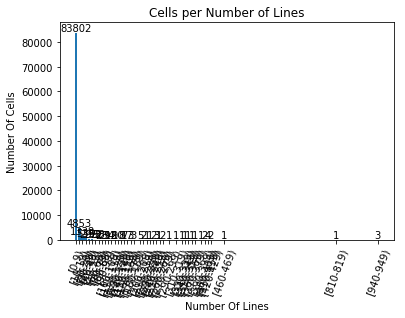

In [2]:
dic = countPrintCells()
xStr = ['[{}-{})'.format(i * 10, i * 10 + (10 - 1)) for i in dic.keys()] + ['[{}-inf)'.format(list(dic.keys())[-1] * 10)]
drawBarPlot(list(dic.keys()), list(dic.values()), xStr=xStr, xLabels='Number Of Lines', yLabels='Number Of Cells', title='Cells per Number of Lines')

There are ~9160 "useless" cells and ~3340 empty cells

#### Possible problems and how we'll handle them:
- Useless (only comments) or empty cells -> we'll Delete them (If necessary for future needs, we can collect more data using the existing infrastructure).
- Cells with many lines (will be harder to classify since they most probably fit more than one class) -> we'll let snorkel (see weak supervision section) "decide" how to tag them . We could've ignore them or seperate them to seprated lines but it didn't seem to make much change.

### Cells per Notebook:

Max value: 9400
Min value: 1
Mean value: 29.364316905801623
Median value: 15.0


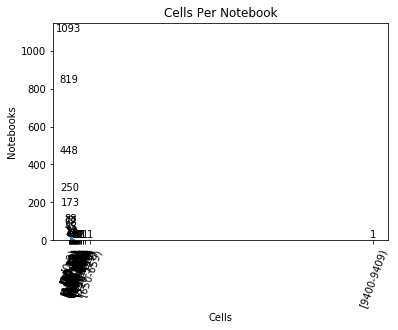

In [3]:
createGraph(diff=10, graphType=graphTypes.CELLS_PER_NOTEBOOKS, xLabels='Cells', yLabels='Notebooks', title='Cells Per Notebook')

There were no empty datasets - and if there were we have would deleted them.

#### Possible problems and how we'll handle them:
- One cell notebooks (all stages in same cell – hard to tag, or just a useless cell) -> if useless we delete, else we let snorkel handle it (as for cells with many lines).

### Notebooks per Datasets:

Max value: 1447
Min value: 1
Mean value: 120.13461538461539
Median value: 34.5


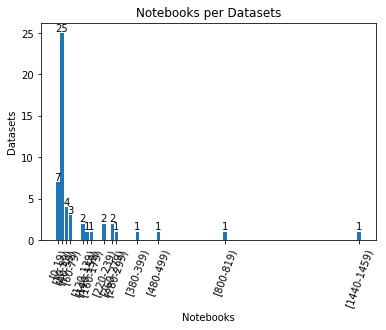

In [4]:
createGraph(diff=20, graphType=graphTypes.NOTEBOOKS_PER_DATASET, xLabels='Notebooks', yLabels='Datasets', title='Notebooks per Datasets')

#### Possible problems and what we did about them:
- Existence of a notebook and a similar notebook with few to no changes (forks)-> Since it's very hard to detect these we manually deleted some, but there might be few that remain.
- Notebooks in the same dataset often have similar cells, so datasets with many notebooks might contain sparse data -> Isn't really a problem since different notebooks should have similar or even identical cells and it doesn't affect our classification process.

# Weak Supervision

We use snorkel new weak-supervison paradigm to tag our unlabeled data with a relatively small amount of noise and with no need to hand-tag a big amount of data.
see
https://github.com/HazyResearch/snorkel

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
import pandas as pd
%config IPCompleter.greedy=True

#start a snorkel session
from snorkel import SnorkelSession
session = SnorkelSession()

## Step 1: Loading & Preprocessing the data

In [6]:
df = pd.read_csv('input/cells.tsv', delimiter='\t',encoding='utf-8')
# we get read of empty cells
clean_df = df[df["Source"].isnull() == False]
#take a first look
clean_df.head(5)

,Cell ID,User Name,Notebook name,Source,Output,Execution count,Label
0,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,from mpl_toolkits.mplot3d import Axes3D\r\r\r\...,[],1,NaN
1,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,print(os.listdir('../input')),[],2,NaN
2,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,# Histogram of column data\r\r\r\ndef plotHist...,[],3,NaN
3,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,# Correlation matrix\r\r\r\ndef plotCorrelatio...,[],4,NaN
4,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,# Scatter and density plots\r\r\r\ndef plotSca...,[],5,NaN


#### Making sure there are no empty cells-

In [7]:
empty_src_df = clean_df[clean_df["Source"] == ""]
print("Empty cells:", len(empty_src_df))
clean_df = clean_df[clean_df["Source"] != ""]
print("Before drop", len(clean_df))
clean_df.dropna()
clean_df = clean_df[clean_df["Source"].isnull() == False]
clean_df = clean_df[clean_df["Cell ID"].isnull() == False]
clean_df.drop_duplicates(inplace=True)
print("After drop", len(clean_df))
print("Unique ID's", len(clean_df["Cell ID"].unique()))

Empty cells: 0
Before drop 91302
After drop 90882
Unique ID's 90882


## Step 2: Defining candidates

In [8]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import NgramMatcher, Matcher
from snorkel.models import Context, Document, Sentence, Span, Candidate, StableLabel,candidate_subclass
from snorkel.contrib.models.text import RawText

# our candidates are cells (what we classify), our values are the classes (Data-Science workflow stages)
cellCand  = candidate_subclass('Cell', ['cell'], values=['Load Data', 'Prep & Clean', 'Train & Param', 'Eval', 'Explore', 'Import', False])

# Our Catagorical classes: Load Data, Data Preparation & Cleaning, Model Train & paramater tunning, model Evaluation, data exploration, import
# Checking candidate cardinality to make sure object created succesfully
cellCand.cardinality

C:\Users\gurya\Anaconda3\envs\snorkel\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


7

### Now we extract candidates from dataset and add them into the current session as candidates:

#### <u> Note: Extracting the candidates may take up to 30 minutes - You can skip to next cell and query the candidates from the saved database </u>

In [ ]:
# Clearing any remaining data on the session
session.rollback()
session.query(Context).delete()
session.query(Candidate).delete()
session.query(Document).delete()
session.query(StableLabel).delete()

for i, row in clean_df.iterrows():
    c_stable_id = row["Cell ID"]
    c_name = 'cell_no_' + str(i)
    c_text = row["Source"]
    if c_stable_id is None or c_name is None or c_text is None:
        continue
    if c_stable_id == "" or c_name == "" or c_text == "":
        continue
    raw_text = RawText(stable_id=c_stable_id, name=c_name , text=c_text)
    if i % 3 != 1:
        # Split 0 is for training - 75%
        candidate = cellCand(cell=raw_text, split=0)
    else:
        # Split 1 is for evaluating - 25%
        candidate = cellCand(cell=raw_text, split=1)
    session.add(candidate)
session.commit()


#### Querying from the stored database

**Continue here** - If you didn't run the previous cell it will query from the previously saved database, and if you did it will query from the most recent session.

In [9]:
train_cands = session.query(cellCand).filter(cellCand.split == 0).all()
dev_cands = session.query(cellCand).filter(cellCand.split == 1).all()

print("Number of Train candidates:", len(train_cands))
print("Number of Dev candidates:", len(dev_cands))

Number of Train candidates: 60600
Number of Dev candidates: 30282


## Step 3: Writing Labeling Functions

**The _categorical_ labeling functions (LFs) we now write can output the following values:**

* Abstain: `None` OR 0.
* Categorical values: One of the six categories we specify above (data science workflow stages classes).

In [10]:
# Getting an example candidate
c0 = train_cands[0]

print(c0.cell.text) # the code
print(c0.cell.stable_id) # unique id








kerneler_#_starter-advance-u-s-international-0372e8f9-5_#_1


### Checking LF arrays
#### Each class has its own array of labeling functions

In [11]:
from utils import LF_utils as lf
print(len(lf.LFs_Load), "LF for class 'Load Data'")
print(len(lf.LFs_Prep), "LF for class 'Prep & Clean'")
print(len(lf.LFs_Train), "LF for class 'Train & Param'")
print(len(lf.LFs_Eval), "LF for class 'Eval'")
print(len(lf.LFs_Explore), "LF for class 'Explore'")
print(len(lf.LFs_Import), "LF for class 'Import'")

1 LF for class 'Load Data'
15 LF for class 'Prep & Clean'
13 LF for class 'Train & Param'
6 LF for class 'Eval'
4 LF for class 'Explore'
1 LF for class 'Import'


You can review or change the labeling functions [here](https://github.com/tamirhuber/Jupyter-Notebook-Cells-Classification/blob/master/utils/LF_utils.py)

### Merging all LF's into one array

In [12]:
LF_helpers = []
LF_helpers = np.concatenate((LF_helpers, lf.LFs_Load), axis=None)
LF_helpers = np.concatenate((LF_helpers, lf.LFs_Prep), axis=None)
LF_helpers = np.concatenate((LF_helpers, lf.LFs_Train), axis=None)
LF_helpers = np.concatenate((LF_helpers, lf.LFs_Eval), axis=None)
LF_helpers = np.concatenate((LF_helpers, lf.LFs_Explore), axis=None)
LF_helpers = np.concatenate((LF_helpers, lf.LFs_Import), axis=None)

print("Total of", len(LF_helpers), "LF are loaded")


Total of 40 LF are loaded


### Adding LF that uses the info from the previous cell
#### * *It is not written in the utils file since it needs to use variables that are definfed in this scope.*

In [13]:
import random
def LF_BeforeCell(c):
    is_plotting = False
    my_labels = []
    for func in LF_helpers:
        res = func(c)
        if res is not None:
            if res not in my_labels:
                my_labels.append(res)
    if len(my_labels) > 0:
        if len(my_labels) == 1:
            if lf.LF_Plotting(c) == None:
                return None
            else:
                is_plotting = True
        else:
            return None
    pre = ""
    pre = lf.getPreCellSource(c, 1)
    raw_text = RawText(stable_id="temp", name='temp_cell', text=pre)
    candidate = cellCand(cell=raw_text, split=2)
    labels = []
    for func in LF_helpers:
        res = func(candidate)
        if res is not None:
            if res not in labels:
                labels.append(res)
    if len(labels) == 0:
        # if previous cell is also empty look for the prevoius of that
        pre = lf.getPreCellSource(c,2)
        raw_text = RawText(stable_id="temp", name='temp_cell', text=pre)
        candidate2 = cellCand(cell=raw_text, split=2)
        for func in LF_helpers:
            res = func(candidate2)
            if res is not None:
                if res not in labels:
                    labels.append(res)
        if len(labels) == 0:
            if is_plotting:
                return lf.LF_Plotting(c)
            return None
    if 'print' in pre or 'print' in c.cell.text or is_plotting:
        if 'Load Data' in labels or 'Prep & Clean' in labels:
            return 'Explore'
        if 'Eval' in labels or 'Train & Param' in labels:
            return 'Eval'
    return random.choice(labels)


In [14]:
# Adding LF that uses the info from the previous cell
LF_arr = LF_helpers.tolist()
LF_arr.append(LF_BeforeCell)
print("Total of", len(LF_arr), "LF are set for applying")

Total of 41 LF are set for applying


#### Testing the "Previous cell" function is working

In [15]:
c = train_cands[126]
print("Cell Source:\n" + c.cell.text)
print("--------\nLF result:", LF_BeforeCell(c))

Cell Source:
plotPerColumnDistribution(df1, 10, 5)
--------
LF result: Explore


#### Now we load our gold label data (hand-labeled)
#### <u> If you skip candidate extraction you may also skip this cell </u>

In [ ]:
from utils.Label_util import load_external_labels
from snorkel.models import StableLabel

# with session.no_autoflush:
session.rollback()
%time missed = load_external_labels(session, cellCand, annotator_name='gold')

In [16]:
from snorkel.annotations import load_gold_labels
L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<30282x1 sparse matrix of type '<class 'numpy.int32'>'
	with 323 stored elements in Compressed Sparse Row format>

#### Unit testing the LF functions of each class on the gold label set

In [17]:
from utils import Eval_utils as eu

print('LF_Import:')
tp, fp, tn, fn = eu.test_LF(session, lf.LFs_Import, 6, split=1, annotator_name='gold')
print('LF_LoadData:')
tp, fp, tn, fn = eu.test_LF(session, lf.LFs_Load, 1, split=1, annotator_name='gold')
print('LF_PrepAndClean:')
tp, fp, tn, fn = eu.test_LF(session, lf.LFs_Prep, 2, split=1, annotator_name='gold')
print('LF_TrainAndParam:')
tp, fp, tn, fn = eu.test_LF(session, lf.LFs_Train, 3, split=1, annotator_name='gold')
print('LF_Eval:')
tp, fp, tn, fn = eu.test_LF(session, lf.LFs_Eval, 4, split=1, annotator_name='gold')
print('LF_Explore:')
tp, fp, tn, fn = eu.test_LF(session, lf.LFs_Explore, 5, split=1, annotator_name='gold')

LF_Import:
Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.923
Precision            0.294
Recall               1.0
F1                   0.455
----------------------------------------
TP: 10 | FP: 24 | TN: 289 | FN: 0

LF_LoadData:
Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.993
Precision            0.935
Recall               1.0
F1                   0.967
----------------------------------------
TP: 29 | FP: 2 | TN: 292 | FN: 0

LF_PrepAndClean:
Scores (Un-adjusted)
Pos. class accuracy: 0.75
Neg. class accuracy: 0.819
Precision            0.637
Recall               0.75
F1                   0.689
----------------------------------------
TP: 72 | FP: 41 | TN: 186 | FN: 24

LF_TrainAndParam:
Scores (Un-adjusted)
Pos. class accuracy: 0.909
Neg. class accuracy: 0.97
Precision            0.862
Recall               0.909
F1                   0.885
----------------------------------------
TP: 50 | FP: 8 | TN: 260 | FN: 5

LF_Eval:
Scores (Un-adjus

some functions are better than others, there are also a lot of collisions (as we are about to see) - noisy.

#### Creating a "Labeler"

In [18]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LF_arr)

### Now we apply the LFs to the candidates of the train set:
#### <u>Note - the following block may take long time (~ 20 minutes)* . You can skip straight to - Loading Labeled Train Set</u> 

In [21]:
%time L_train = labeler.apply(split=0)

Clearing existing...
Running UDF...
[========================================] 100%

Wall time: 18min 7s


#### Loading Labeled Train Set

In [22]:
%time L_train = labeler.load_matrix(session, split=0)
L_train

Wall time: 489 ms


<60600x41 sparse matrix of type '<class 'numpy.int32'>'
	with 102539 stored elements in Compressed Sparse Row format>

*(should be 102539 stored elements)*

#### Showing some of the labeling results (using the labeling functions with no weights)

In [24]:
c = L_train.get_candidate(session, 0)
print(c.labels) #labels
print(c.cell.text) #code
print("##########\n\n")

c = L_train.get_candidate(session, 1)
print(c.labels) #labels
print(c.cell.text) #code
print("##########\n\n")

c = L_train.get_candidate(session, 2)
print(c.labels) #labels
print(c.cell.text) #code
print("##########\n\n")


[Label (LF_Import = 6)]







##########


[Label (LF_Def = 2), Label (LF_Loc = 2), Label (LF_Sizes = 5), Label (LF_Plotting = 5)]

















##########


[Label (LF_Def = 2), Label (LF_Drop = 2), Label (LF_Sizes = 5), Label (LF_Plotting = 5)]


















##########




We can see, as we mentioned before. that there are overlaps. Different LFs don't agree.

#### LF functions Mutual Statistics

In [25]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_Read,0,0.082789,0.053300,0.033465
LF_Def,1,0.071733,0.065165,0.057954
LF_Concat,2,0.089340,0.070957,0.059455
LF_Split,3,0.014521,0.011667,0.010314
LF_Drop,4,0.069175,0.056353,0.050165
LF_Fill,5,0.027228,0.026568,0.017690
LF_Nulls,6,0.040776,0.036172,0.026238
LF_Loc,7,0.086634,0.051353,0.042921
LF_Transformions,8,0.017558,0.017475,0.014604
LF_TransformOps,9,0.028812,0.025083,0.020941


labeling using only labeling functions is very noisy because of these overlaps and conflicts.
Snorkel uses a generative model to decide which function is "better" for each case.
So we can add "weights" to the labeling functions and get a more decisive and less noisy results.

## Step 4: Training the Generative Model

In [27]:
from snorkel.learning import GenerativeModel
gen_model = GenerativeModel()

#### <u>Note - the following cell may take long time to execute* You can skip straight to - Loading the Generative Model 

In [28]:
# Note: We pass cardinality explicitly here to be safe
gen_model.train(L_train, cardinality=6)
gen_model.save()

[GenerativeModel] Model saved as <GenerativeModel>.


#### Loading the trained Generative Model

In [29]:
gen_model.load()

[GenerativeModel] Model <GenerativeModel> loaded.


#### LFs accuracy with generative model weights

In [36]:
gen_model.weights.lf_accuracy

array([ 0.87294326,  0.76095531,  0.77436239,  0.8102736 ,  0.77710674,
        0.82689887,  0.80869655,  0.75896682,  0.84025763,  0.83601208,
        0.82923128,  0.8188154 ,  0.81198168,  0.8359479 ,  0.82047706,
        0.83228475,  0.83467427,  0.81044449,  0.83318115,  0.81684898,
        0.81811295,  0.83616299,  0.82991168,  0.83494811,  0.82923132,
        0.82436705,  0.81999692,  0.82482878,  0.82995391,  0.82427681,
        0.82496562,  0.81698995,  0.82274617,  0.82808388,  0.82639357,
        0.99977425,  0.95140791,  1.05548462,  0.81697665,  0.72778412,
        1.09724267])

#### Generate Train Marginals
#### <u> Note - the following cell may take few minutes</u> 

In [31]:
train_marginals = gen_model.marginals(L_train)

### Now we apply the LFs to the candidates of the test set:
#### <u>Note - the following cell may take long time (~ 30 minutes)* . You can skip straight to - Loading Labeled Test Set</u>

In [32]:
L_test = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



#### Loading Labeled Test Set

In [37]:
%time L_test = labeler.load_matrix(session, split=1)
L_test

Wall time: 533 ms


<30282x41 sparse matrix of type '<class 'numpy.int32'>'
	with 51108 stored elements in Compressed Sparse Row format>

#### Generate Test Marginals
#### <u> Note - the following cell may take few minutes </u> 

In [38]:
from snorkel.annotations import save_marginals
test_marginals = gen_model.marginals(L_test)

#### Loading Gold Labels to test Snorkel results

In [39]:
labeled = pd.read_csv('input/gold_labels.tsv',delimiter='\t',encoding='utf-8')
print("Total labeled data:", len(labeled))
labeled.head()

Total labeled data: 1025


,cell,label
0,kerneler_#_starter-advance-u-s-international-0...,6
1,kerneler_#_starter-advance-u-s-international-0...,1
2,kerneler_#_starter-advance-u-s-international-1...,1
3,kerneler_#_starter-advance-u-s-international-1...,1
4,kerneler_#_starter-advance-u-s-international-3...,1


In [40]:
# Clearing any session errors and checking the test set size
session.rollback()
L_test.shape[0]

30282

#### Querying  the gold labeled test set candidates from the session
#### <u> Doing this once and saving only the important indexes of those candidates to improve time in future, this might take a few minutes</u>

In [41]:
tag_cand_index = []
for i in range(0, L_test.shape[0]):
    cand = L_test.get_candidate(session, i)
    cell_id = cand.cell.stable_id
    is_tagged = len(labeled[labeled["cell"] == cell_id])
    if is_tagged > 0:
        tag_cand_index.append(i)
print("Total labeled data in the test-set:", len(tag_cand_index))

Total labeled data in the test-set: 323


#### Reload labeld data (if any updates were made -mosly used to check errors in gold lables)

In [42]:
# This was used in order to fix hand tagged errors and re-test the model result.
labeled = pd.read_csv('input\gold_labels.tsv',delimiter='\t',encoding='utf-8')
print("Total labeled data:", len(labeled))

Total labeled data: 1025


#### now let's check our categorical accuracy with the gold labels test set:

In [43]:
from utils import Eval_utils as eu
y_pred_arr, y_true_arr = eu.calc_lf_acc(session, tag_cand_index, L_test, test_marginals, labeled)

Accuracy -  82.35294117647058%


It essentially means that we got 82.3% of the labels right. Not bad! let's see a more detailed report.

#### Classification Report

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_true_arr, y_pred_arr))


This is SKlearn report:
------------------


              precision    recall  f1-score   support

         1.0       0.71      1.00      0.83        29
         2.0       0.96      0.69      0.80        96
         3.0       0.94      0.89      0.92        55
         4.0       0.79      0.70      0.75        44
         5.0       0.72      0.91      0.81        89
         6.0       1.00      1.00      1.00        10

   micro avg       0.82      0.82      0.82       323
   macro avg       0.85      0.87      0.85       323
weighted avg       0.85      0.82      0.82       323



We can see that we label some of the data preparation cells as data exploration, as data preparation recall is lower and data exploration precision is lower, but that’s a hard task. Overall the results are pretty good.  

## Step 5: Labeling the data

In [46]:
Labels_str = ['Unknown', 'Load', 'Prep', 'Train', 'Eval', 'Explore', 'Import']
tagged_df = clean_df.copy()
#add a new column for the label
tagged_df["Label"] = ""
tagged_df.head(1) #just to check the column was added

,Cell ID,User Name,Notebook name,Source,Output,Execution count,Label
0,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,from mpl_toolkits.mplot3d import Axes3D\r\r\r\...,[],1,


We tag the data according to the highest probability in the generative model output-

#### <u> Note - the following cell may take a long time to execute (~15 minutes). you can skip to stage 6 and use existing tagged data in the next notebook</u> 

In [47]:
#Set label according to the highest probabiltiy
for i,cand in enumerate(train_cands):
    marg = train_marginals[i]
    id = cand.cell.stable_id
    boolcol = (tagged_df["Cell ID"] == id)
    idx = tagged_df.index[boolcol][0]
    max =  marg.max()
    labels = np.where(marg == max)[0]
    if len(labels) > 1:
        label = 0
    else:
        label = labels[0] + 1
    
    tagged_df.at[idx, "Label"] = Labels_str[label]
        
for i in range(0, L_test.shape[0]):
    marg = test_marginals[i]
    cand = L_test.get_candidate(session, i)
    id = cand.cell.stable_id
    boolcol = (tagged_df["Cell ID"] == id)
    idx = tagged_df.index[boolcol][0]
    max =  marg.max()
    labels = np.where(marg == max)[0]
    if len(labels) > 1:
        label = 0
    else:
        label = labels[0] + 1
    
    tagged_df.at[idx, "Label"] = Labels_str[label]
tagged_df.head(5) #just to see some tags

,Cell ID,User Name,Notebook name,Source,Output,Execution count,Label
0,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,from mpl_toolkits.mplot3d import Axes3D\r\r\r\...,[],1,Import
1,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,print(os.listdir('../input')),[],2,Import
2,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,# Histogram of column data\r\r\r\ndef plotHist...,[],3,Explore
3,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,# Correlation matrix\r\r\r\ndef plotCorrelatio...,[],4,Explore
4,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,# Scatter and density plots\r\r\r\ndef plotSca...,[],5,Prep
5,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,nRowsRead = 1000 # specify 'None' if want to r...,[],6,Load
6,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,df1.head(5),[],7,Explore
7,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,"plotHistogram(df1, 10, 5)",[],8,Explore
8,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,nRowsRead = 1000 # specify 'None' if want to r...,[],9,Load
9,kerneler_#_starter-advance-u-s-international-0...,kerneler,starter-advance-u-s-international-0372e8f9-5.i...,df2.head(5),[],10,Explore


Export tagged dataset-

In [48]:
import csv
tagged_df.to_csv('input/input.tsv', sep='\t', quotechar='"', quoting=csv.QUOTE_MINIMAL)

The tagged dataset will be used to train a supervised end-classification-model.

## Step 6: End Model

### Going to End-Model notebook
##### In case the last cell didn't work (it's supposed to launch  'Classification.ipynb'), please click [here](Classification.ipynb) to open the notebook manually


In [50]:
%%javascript
window.open('http://localhost:8888/notebooks/Jupyter-Notebook-Cells-Classification/Classification.ipynb')

<IPython.core.display.Javascript object>